In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pyrealsense2 as rs
import torch
import pandas as pd
print("Environment Set")

Environment Set


In [2]:
pipe = rs.pipeline()
cfg = rs.config()
cfg.enable_device_from_file("test_bag/20241126_074454.bag")
profile = pipe.start(cfg)

for _ in range(15):
    pipe.wait_for_frames()

frameset = pipe.wait_for_frames()
color_frame = frameset.get_color_frame()
depth_frame = frameset.get_depth_frame()

pipe.stop()
print("Frames Captured")

Frames Captured


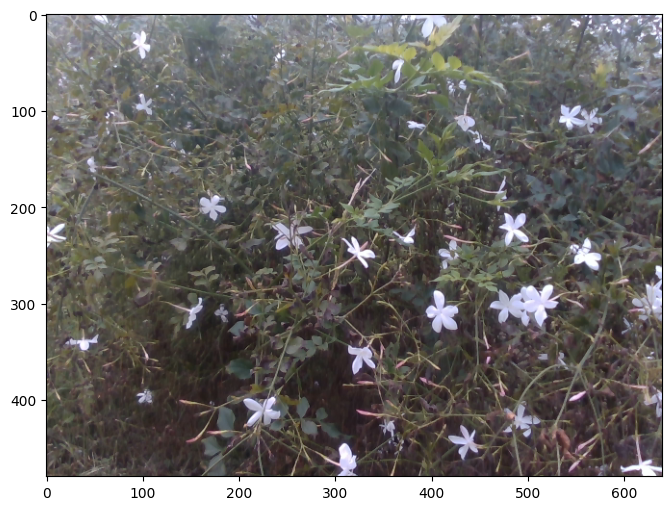

In [3]:
color = np.asanyarray(color_frame.get_data())
plt.rcParams["axes.grid"] = False
plt.rcParams['figure.figsize'] = [12, 6]
plt.imshow(color)

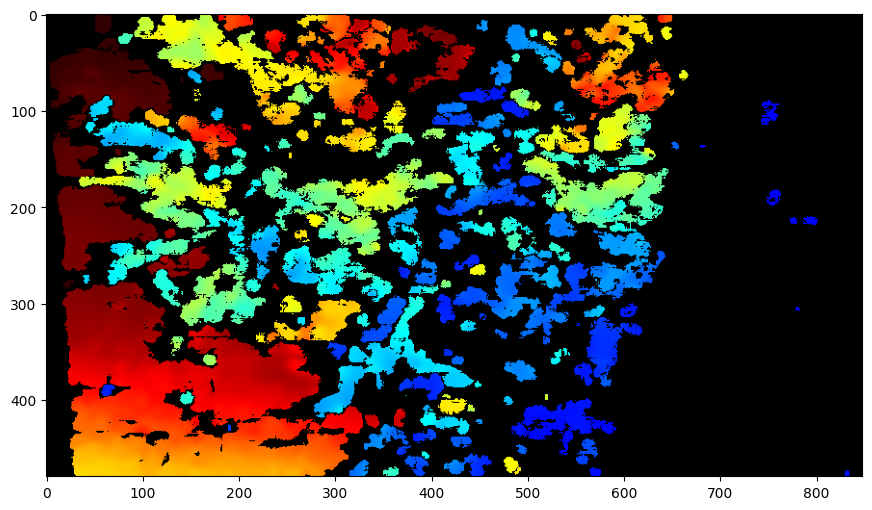

In [4]:
colorizer = rs.colorizer()
colorized_depth = np.asanyarray(colorizer.colorize(depth_frame).get_data())
plt.imshow(colorized_depth)

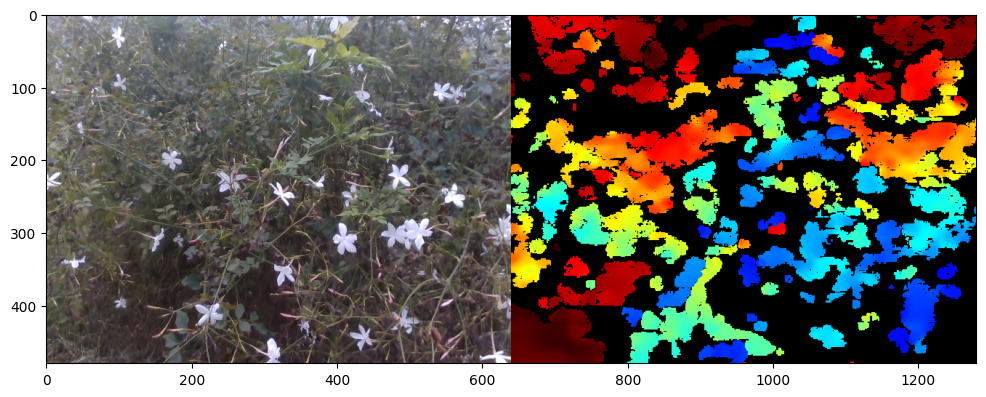

In [5]:
# Create alignment primitive with color as its target stream:
align = rs.align(rs.stream.color)
frameset = align.process(frameset)

# Update color and depth frames:
aligned_depth_frame = frameset.get_depth_frame()
colorized_depth = np.asanyarray(colorizer.colorize(aligned_depth_frame).get_data())

# Show the two frames together:
images = np.hstack((color, colorized_depth))
plt.imshow(images)

In [6]:
def load_model():
    weights = "trained_weights/yolov7_best_v3.pt"
    model = torch.hub.load("yolov7", "custom", weights, source="local", trust_repo=True)
    return model

model = load_model()

yolov7\hubconf.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(path_or_model, map_location=torch.device('cpu')) if isinstance(path_or_model, str) els

Adding autoShape... 


In [7]:
def class_map(class_id):
    class_names = {0: "Bud", 1: "Flower"}
    return class_names.get(class_id, "Unknown")

In [8]:
results = model(color)
detections = results.xyxy[0].cpu().numpy()  # [x_min, y_min, x_max, y_max, confidence, class_id]
detection_df = pd.DataFrame(detections, columns=["x_min", "y_min", "x_max", "y_max", "confidence", "class_id"])
detection_df["class_name"] = detection_df["class_id"].apply(class_map)

depth_scale = profile.get_device().first_depth_sensor().get_depth_scale()

# Calculate the depth for each detected box
depths = []
for _, row in detection_df.iterrows():
    try:
        x_min, y_min, x_max, y_max = map(int, [row["x_min"], row["y_min"], row["x_max"], row["y_max"]])
        
        # Ensure coordinates are within frame bounds
        height, width = np.asanyarray(aligned_depth_frame.get_data()).shape
        x_min, y_min = max(0, x_min), max(0, y_min)
        x_max, y_max = min(width-1, x_max), min(height-1, y_max)
        
        # Get depth ROI
        depth_roi = np.asanyarray(aligned_depth_frame.get_data())[y_min:y_max, x_min:x_max]
        
        # Calculate mean depth, handling empty arrays
        if depth_roi.size > 0 and np.any(depth_roi > 0):
            depth = np.mean(depth_roi[depth_roi > 0]) * depth_scale  # Convert to meters
            depths.append(depth)
        else:
            depths.append(0)  # No valid depth data
            print(f"No valid depth data for detection at ({x_min},{y_min},{x_max},{y_max})")
    except Exception as e:
        print(f"Error calculating depth: {e}")
        depths.append(0)  # Append zero on error

yolov7\models\common.py:921: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(enabled=p.device.type != 'cpu'):


No valid depth data for detection at (599,459,638,479)
No valid depth data for detection at (203,146,214,163)
No valid depth data for detection at (620,386,639,421)


In [12]:
# Calculate center x and center y
detection_df['center_x'] = (detection_df['x_min'] + detection_df['x_max']) / 2
detection_df['center_y'] = (detection_df['y_min'] + detection_df['y_max']) / 2

# Create a new DataFrame with center_x, center_y, and depths
center_depth_df = pd.DataFrame({
    'class':detection_df['class_name'],
    'center_x': detection_df['center_x'],
    'center_y': detection_df['center_y'],
    'depth': depths
})

print(center_depth_df)

     class    center_x    center_y     depth
0   Flower  486.486206  223.083649  0.552235
1   Flower  411.335449  310.760071  0.519421
2   Flower  434.084747  444.113739  0.535722
3   Flower  560.462830  249.239899  0.566580
4   Flower  224.576767  412.634583  0.565402
5   Flower  543.850891  106.745163  0.771521
6      Bud  551.364014  396.668915  0.456700
7   Flower  514.127075  301.500732  0.482000
8   Flower  325.137482  248.091263  0.500617
9   Flower  493.761536  422.289856  0.622217
10  Flower  172.906769  199.937180  0.719489
11  Flower  619.026611  469.589325  0.000000
12  Flower   99.149757   32.472351  0.749822
13  Flower   10.833441  229.459000  0.617922
14  Flower  153.921799  310.428009  0.623128
15  Flower  102.760681  397.925720  1.002708
16  Flower  328.575775  356.209656  0.444808
17  Flower  476.135742  302.864380  0.568137
18  Flower  313.030579  462.725159  0.469438
19  Flower  435.701050  111.580055  0.632216
20  Flower  102.482750   93.276855  0.918299
21  Flower

In [14]:
filtered_df = center_depth_df[center_depth_df["class"] == 'Flower']
filtered_df

,class,center_x,center_y,depth
0,Flower,486.486206,223.083649,0.552235
1,Flower,411.335449,310.760071,0.519421
2,Flower,434.084747,444.113739,0.535722
3,Flower,560.462830,249.239899,0.566580
4,Flower,224.576767,412.634583,0.565402
5,Flower,543.850891,106.745163,0.771521
7,Flower,514.127075,301.500732,0.482000
8,Flower,325.137482,248.091263,0.500617
9,Flower,493.761536,422.289856,0.622217
10,Flower,172.906769,199.937180,0.719489


In [10]:
center_depth_df.to_csv("center_depth_data.csv", index=False)

In [16]:
filtered_df[["center_x","center_y","depth"]].to_csv("flower_only_csv.csv", index=False)